In [26]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import PIL 
import numpy as np
import os
import plotly.graph_objects as go
import seaborn as sns
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from random import sample

import warnings

warnings.filterwarnings('ignore')

In [27]:
data_dir = image_dataset_from_directory(
    '../cacao_photos/',
    label_mode='int')


Found 2829 files belonging to 3 classes.


In [28]:
class_names = data_dir.class_names

def count_data_per_class() -> None:
    for class_name in class_names:
        print(class_name, ":", len(os.listdir("../cacao_photos/"+class_name)))

def get_class_count(class_name:str) -> int:

    if class_name in class_names:
        return len(os.listdir("../cacao_photos/"+class_name))
    else:
        return 0

count_data_per_class()
get_class_count('black_pod_rot')

black_pod_rot : 943
healthy : 943
pod_borer : 943


943

In [29]:
healthy_path = "../cacao_photos/healthy"
healthy = os.listdir(healthy_path)
for file in sample(healthy,(get_class_count('healthy')-get_class_count('black_pod_rot'))):
    os.remove(healthy_path+"/"+file)

In [30]:
count_data_per_class()

black_pod_rot : 943
healthy : 943
pod_borer : 943


## Data Preparation

In [31]:

batch_size = 1
img_height = 224
img_width = 224
epochs = 30

In [32]:
train_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 2264 files for training.


In [33]:
validation_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 565 files for validation.


In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
normalization_layer = layers.Rescaling(1./255)

In [36]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [37]:
from tensorflow.keras.applications import EfficientNetB0

In [38]:
num_classes = len(class_names)

pretrained_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False
for layer in pretrained_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model = Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=4)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [39]:
from tensorflow.keras.callbacks import TensorBoard

file_name = 'results_EfficientNetB0_RMSprop'

tensorboard = TensorBoard(log_dir="../logs\\{}".format(file_name))

In [40]:
model_history = model.fit(train_dataset,
                                  epochs=epochs,
                                  callbacks = [early_stopping, tensorboard],
                                  validation_data=validation_dataset)

Epoch 1/30
2264/2264 [==============================] - 140s 51ms/step - loss: 0.4248 - accuracy: 0.8140 - val_loss: 0.2743 - val_accuracy: 0.8938
Epoch 2/30
2264/2264 [==============================] - 141s 62ms/step - loss: 0.2864 - accuracy: 0.8865 - val_loss: 0.2719 - val_accuracy: 0.8920
Epoch 3/30
2264/2264 [==============================] - 172s 76ms/step - loss: 0.2321 - accuracy: 0.9099 - val_loss: 0.2671 - val_accuracy: 0.8956
Epoch 4/30
2264/2264 [==============================] - 131s 58ms/step - loss: 0.2357 - accuracy: 0.9090 - val_loss: 0.2818 - val_accuracy: 0.8903
Epoch 5/30
2264/2264 [==============================] - 133s 59ms/step - loss: 0.2202 - accuracy: 0.9214 - val_loss: 0.2605 - val_accuracy: 0.9062
Epoch 6/30
2264/2264 [==============================] - 127s 56ms/step - loss: 0.2264 - accuracy: 0.9236 - val_loss: 0.2607 - val_accuracy: 0.9133
Epoch 7/30
2264/2264 [==============================] - 110s 49ms/step - loss: 0.2157 - accuracy: 0.9205 - val_loss: 0

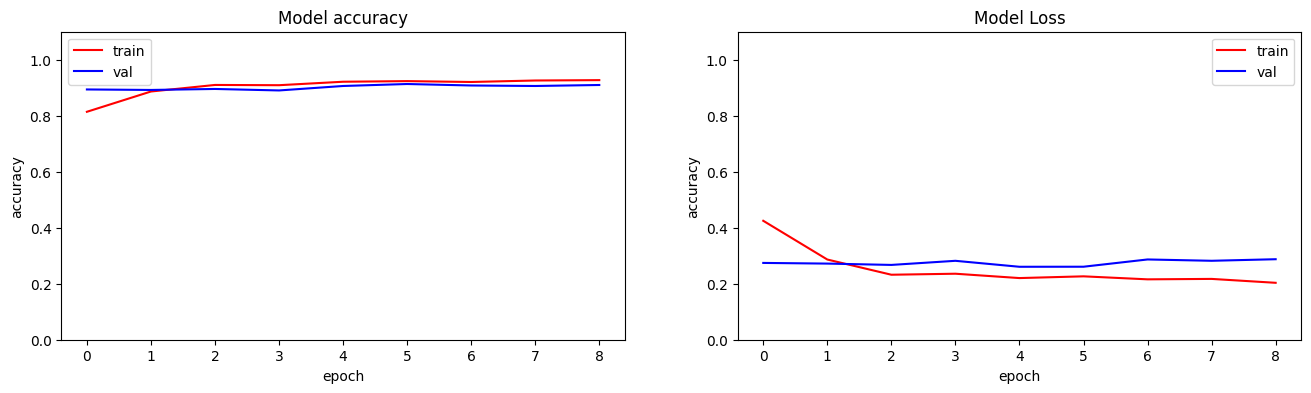

In [41]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], color="red")
plt.plot(model_history.history['val_accuracy'], color="blue")
plt.title('Model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], color="red")
plt.plot(model_history.history['val_loss'], color="blue")
plt.title('Model Loss')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [42]:

def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss with respect to Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy with respect to Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Training"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validation"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()



In [43]:
display_training_curves(
    model_history.history['accuracy'], 
    model_history.history['val_accuracy'], 
    'accuracy')

In [44]:
display_training_curves(
    model_history.history['loss'], 
    model_history.history['val_loss'], 
    'validation')

In [45]:
val_pred = model.predict(validation_dataset)

565/565 [==============================] - 23s 31ms/step


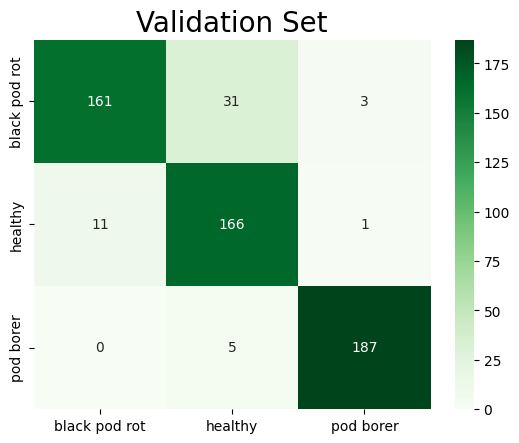

In [46]:


labels = []
preds = []
for _, label in validation_dataset.as_numpy_iterator():
    for i in label:
        labels.append(i)

for pred in val_pred:
    pred_list = pred.tolist()
    preds.append(pred_list.index(max(pred_list)))

val_cm = confusion_matrix(labels, preds, labels=[0,1,2],)
val_axis_labels = ['black pod rot', 'healthy', 'pod borer']
plt.title("Validation Set", fontsize =20)
val_ax = sns.heatmap(val_cm,
                 cmap="Greens",
                 annot=True,
                 xticklabels=val_axis_labels,
                 yticklabels=val_axis_labels,
                 fmt="d")

In [47]:
print(classification_report(labels, preds, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       195
           1       0.82      0.93      0.87       178
           2       0.98      0.97      0.98       192

    accuracy                           0.91       565
   macro avg       0.91      0.91      0.91       565
weighted avg       0.91      0.91      0.91       565

